In [1]:
import json, mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas

In [2]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1')
cur = conn.cursor()
cur.execute("use yelp;")

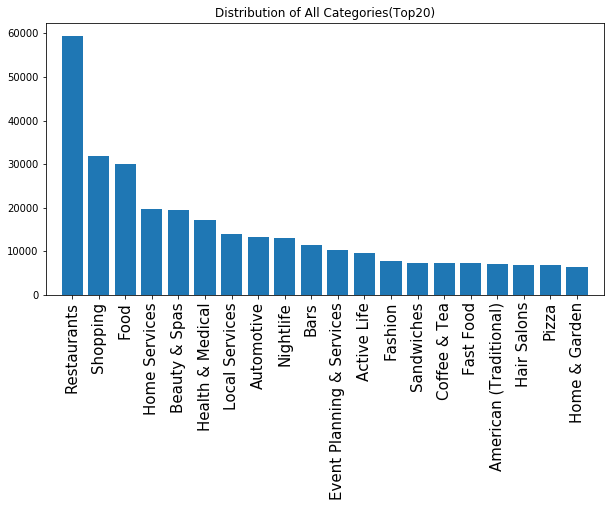

In [3]:
query = '''select category_name, Num FROM(
    select category_id, count(*) as Num from CategoryXBusiness group by category_id)a
    INNER JOIN Categories USING(category_id) order by Num desc;'''
cur.execute(query)
res = cur.fetchall()
labels = [x[0] for x in res[:20]]
num = [x[1] for x in res[:20]]
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(range(len(labels)), num)
plt.xticks(range(len(labels)), labels, rotation=90, fontsize = 15)
plt.xlim([-1,len(labels)])
plt.title('Distribution of All Categories(Top20)')
# fig.savefig('distributionAllCategories.png', dpi=250, bbox_inches='tight')
plt.show()

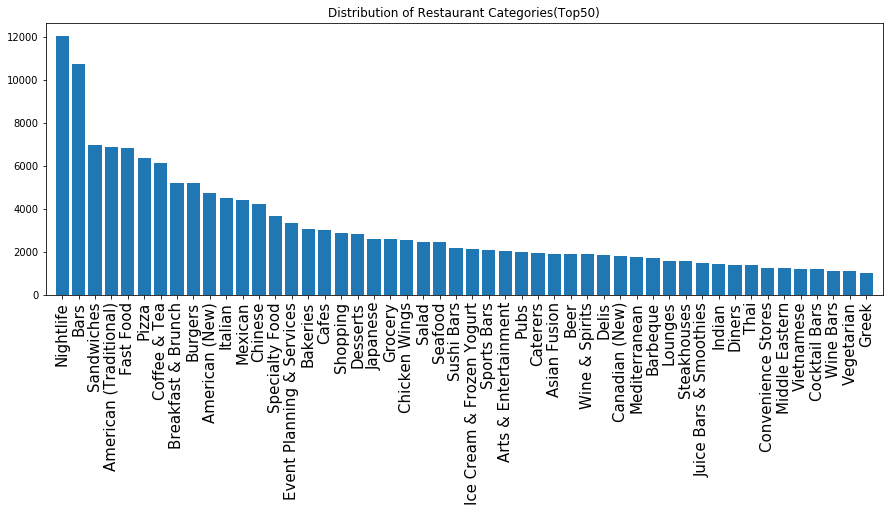

In [4]:
query = '''SELECT category_name, Num FROM
            (SELECT category_id, count(*) as Num FROM
            (SELECT DISTINCT business_id FROM AttributeXBusiness 
            WHERE attribute_id IN (10, 11, 18, 24, 26, 29, 32))restaurants
            INNER JOIN CategoryXBusiness ON restaurants.business_id = CategoryXBusiness.business_id
            group by category_id)a INNER JOIN Categories USING(category_id) order by Num desc;'''
cur.execute(query)
res = cur.fetchall()
labels = [x[0] for x in res[2:52]]
num = [x[1] for x in res[2:52]]
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(range(len(labels)), num)
plt.xticks(range(len(labels)), labels, rotation=90, fontsize = 15)
plt.xlim([-1,len(labels)])
plt.title('Distribution of Restaurant Categories(Top50)')
# fig.savefig('distributionRestaurants.png', dpi=250, bbox_inches='tight')
plt.show()

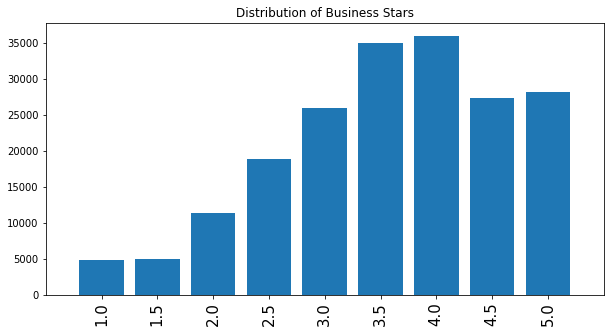

In [5]:
cur.execute('SELECT stars, COUNT(*) FROM Business GROUP BY stars order by stars;')
res = cur.fetchall()
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(range(9), [x[1] for x in res])
plt.xticks(range(9), [x[0] for x in res], rotation=90, fontsize = 15)
plt.xlim([-1,9])
plt.title('Distribution of Business Stars')
# fig.savefig('distributionBusinessStars.png', dpi=250, bbox_inches='tight')
plt.show()

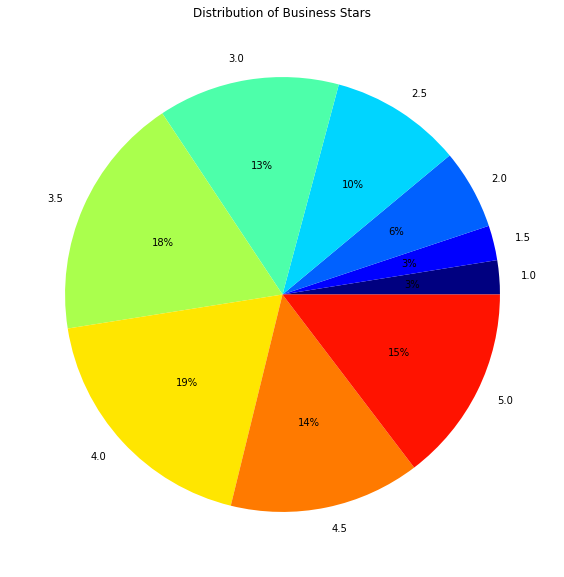

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
theme = plt.get_cmap('jet')
ax.set_prop_cycle("color", [theme(1. * i / 9) for i in range(9)])
plt.pie([x[1] for x in res], labels = [x[0] for x in res], autopct='%1.0f%%')
plt.title('Distribution of Business Stars')
# fig.savefig('distributionBusinessStarsPie.png', dpi=250, bbox_inches='tight')
plt.show()

In [7]:
cur.execute('SELECT distinct longitude, latitude from Business;')
df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [8]:
shp = geopandas.read_file('SHP/USA_Canada_ShapefileMerge.shp').drop([0, 1, 2, 5, 11, 12, 13, 14, 15, 16, 75, 30, 32, 40, 42, 54, 56, 60, 70, 72]).reset_index(drop=True)
states = {"Alabama": "AL", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC",
          "Florida": "FL", "Georgia": "GA", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", 
          "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", 
          "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", 
          "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", 
          "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", 
          "Wisconsin": "WI", "Wyoming": "WY", "BRITISH COLUMBIA": "BC", "QUEBEC": "QC", "ALBERTA": "AB", "SASKATCHEWAN": "SK", "MANITOBA": "MB", "ONTARIO": "ON", 
          "QUEBEC": "QC"}
shp['abbr'] = shp['StateName'].map(states)

In [9]:
cur.execute('select state as abbr, COUNT(*) as Num from Business where state not in("BAS", "CON", "DOW", "DUR", "XGL", "XGM", "XWY") group by state;')
shp = pd.merge(shp, pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description]), on='abbr', how='outer').drop([56]).fillna(0)

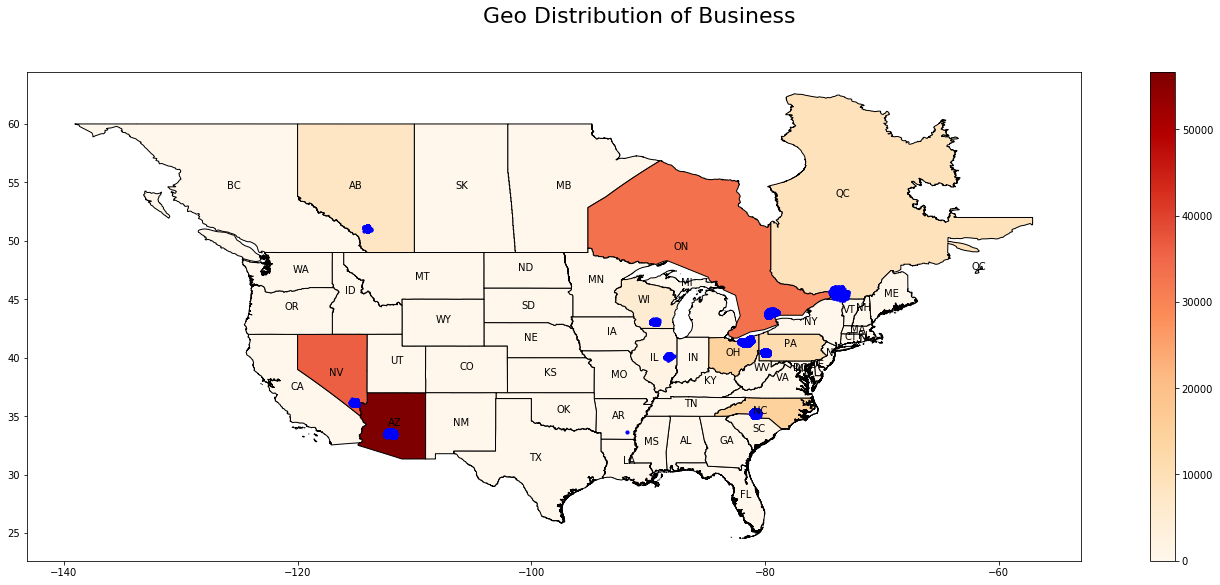

In [10]:
shp['coords'] = shp['geometry'].apply(lambda x: x.representative_point().coords[:])
shp['coords'] = [coords[0] for coords in shp['coords']]
ax = shp.plot(column='Num', edgecolor='black', figsize=(25,9), legend=True, cmap='OrRd')
gdf.plot(ax=ax, color='blue', markersize=10)
for idx, row in shp.iterrows():
    plt.annotate(s=row['abbr'], xy=row['coords'],horizontalalignment='center')
plt.suptitle("Geo Distribution of Business", fontsize= 22)
# fig = ax.get_figure()
# fig.savefig('distributionBusinessGeo.png', dpi=300, bbox_inches='tight')
plt.show()

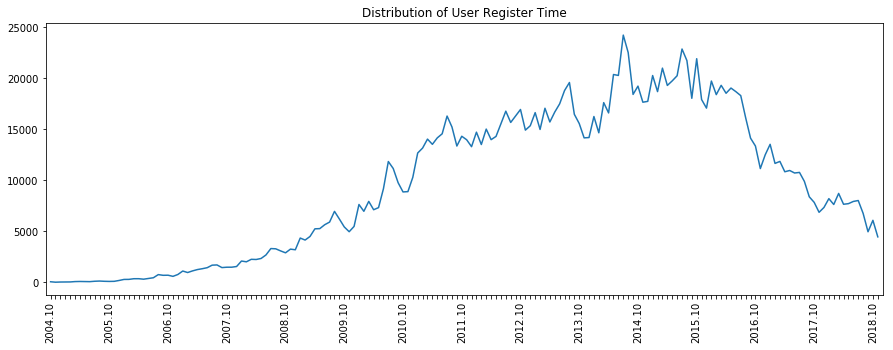

In [11]:
cur.execute('''SELECT YEAR(yelping_since), MONTH(yelping_since), COUNT(*) as Num 
                FROM Users GROUP BY YEAR(yelping_since), MONTH(yelping_since) 
                order by YEAR(yelping_since), MONTH(yelping_since);''')
res = cur.fetchall()
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(range(len(res)), [x[2] for x in res])
plt.xticks(range(len(res)), [str(res[x][0])+'.'+str(res[x][1]) if x%12==0 else None for x in range(len(res))], rotation=90, fontsize = 10)
plt.xlim([-1,len(res)])
plt.title('Distribution of User Register Time')
# fig.savefig('distributionUserRegisterTime.png', dpi=200, bbox_inches='tight')
plt.show()

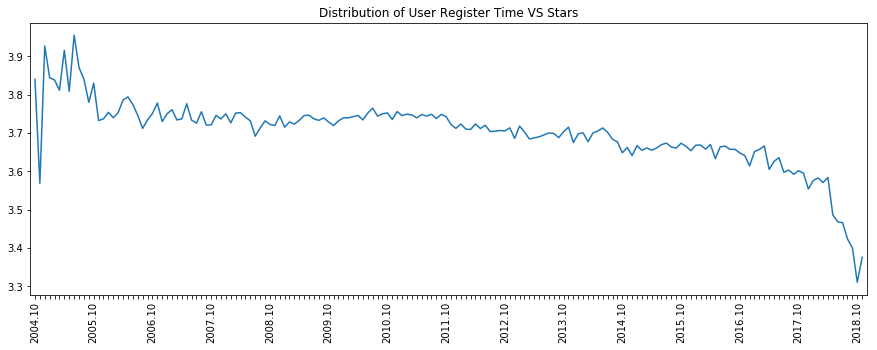

In [12]:
cur.execute('''SELECT YEAR(yelping_since), MONTH(yelping_since), AVG(average_stars) FROM Users 
            GROUP BY YEAR(yelping_since), MONTH(yelping_since) order by YEAR(yelping_since), MONTH(yelping_since);''')
res = cur.fetchall()
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(range(len(res)), [x[2] for x in res])
plt.xticks(range(len(res)), [str(res[x][0])+'.'+str(res[x][1]) if x%12==0 else None for x in range(len(res))], rotation=90, fontsize = 10)
plt.xlim([-1,len(res)])
plt.title('Distribution of User Register Time VS Stars')
# fig.savefig('distributionUserRegisterTimeStars.png', dpi=200, bbox_inches='tight')
plt.show()

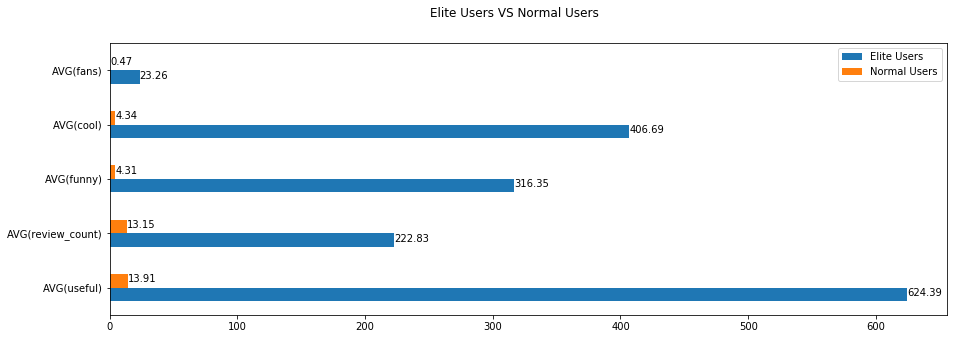

In [13]:
cur.execute('''SELECT * FROM( SELECT AVG(useful), 
            AVG(review_count), AVG(funny), AVG(cool), AVG(fans) FROM
            (SELECT distinct user_id FROM EliteYears)u
            INNER JOIN Users USING(user_id))a
            UNION
            (SELECT AVG(useful), AVG(review_count), AVG(funny), AVG(cool), AVG(fans) FROM
            (SELECT distinct user_id FROM Users LEFT JOIN EliteYears USING(user_id) WHERE EliteYears.user_id IS NULL)u
            INNER JOIN Users USING(user_id));''')
df = pd.DataFrame(cur.fetchall(), index=['Elite Users', 'Normal Users'], columns=[x[0] for x in cur.description]).T.astype(float)
ax = df.plot.barh(figsize=(15,5))
plt.suptitle("Elite Users VS Normal Users")
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.1, str(round((i.get_width()), 2)))
# fig = ax.get_figure()
# fig.savefig('eliteVSNormalUsers.png', dpi=200, bbox_inches='tight')
plt.show()

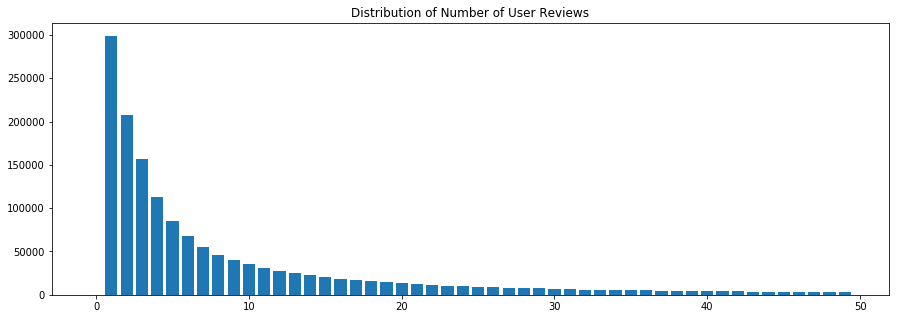

In [14]:
cur.execute('''SELECT review_count, count(review_count) FROM Users 
            group by review_count order by review_count limit 50;''')
res = cur.fetchall()
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(range(len(res)), [x[1] for x in res])
plt.title('Distribution of Number of User Reviews')
# fig.savefig('distributionNumUserReviews.png', dpi=200, bbox_inches='tight')
plt.show()

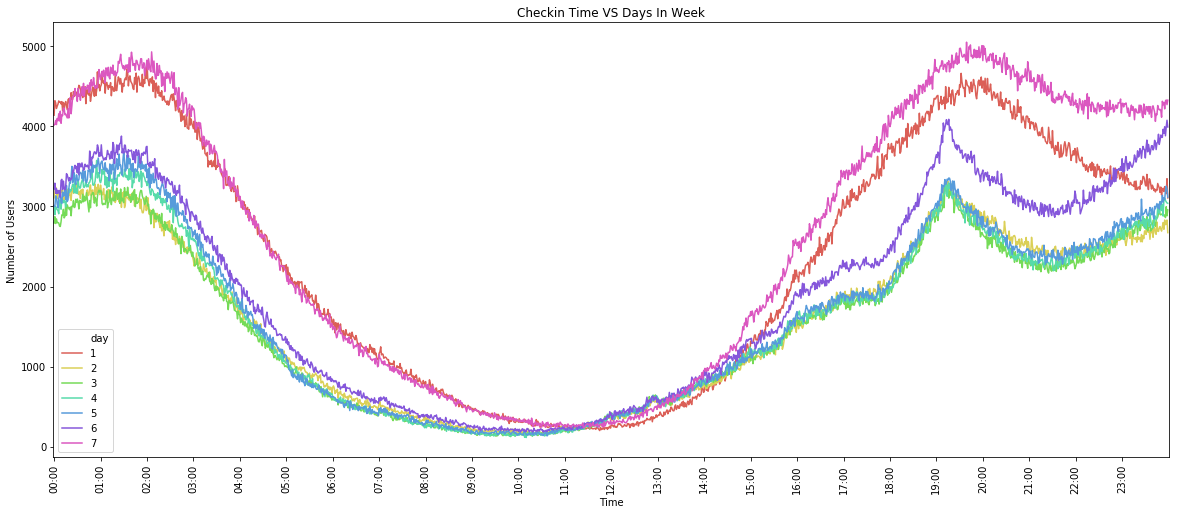

In [15]:
cur.execute('''select DATE_FORMAT(checkin_date,'%H:%i')t, dayofweek(checkin_date)day, 
        COUNT(DATE_FORMAT(checkin_date,'%H:%i')) as Num 
        FROM Checkin group by t, day order by day, t;''')
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(ax=ax, x='t', y='Num', hue='day', data=pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description]), legend="full", palette=sns.color_palette("hls", 7))
ax.set_xticks(range(0, 24*60, 60))
ax.set_xticklabels([format(x, '02')+':00' for x in range(24)], rotation='vertical', fontsize=10)
ax.set_ylabel('Number of Users')    
ax.set_xlabel('Time')
ax.set_xlim(-1, 1441)
ax.set_title('Checkin Time VS Days In Week')
# fig = ax.get_figure()
# fig.savefig('checkinTimeVSDay.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
cur.execute('''select LENGTH(content) - LENGTH(REPLACE(content, ' ', '')) +1 as wordCount, 
            AVG(useful) from reviews GROUP BY wordCount order by wordCount limit 1000''')
res = cur.fetchall() # takes 1min50s to run

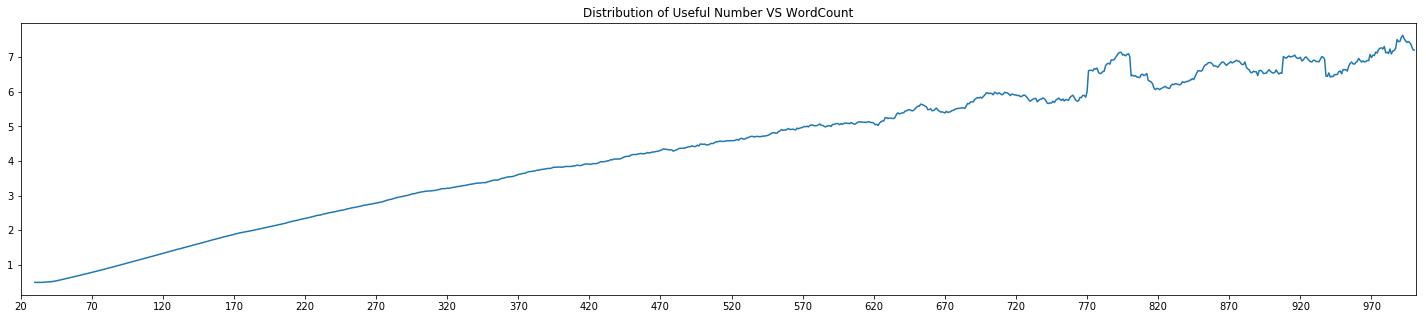

In [43]:
df = pd.DataFrame(res, columns=[x[0] for x in cur.description])
fig, ax = plt.subplots(figsize=(25,5))
plt.plot(df['wordCount'], df['AVG(useful)'].rolling(window=30).mean())
plt.xticks(range(20, len(res)+1, 50))
plt.xlim([20,len(res)+1])
plt.title('Distribution of Useful Number VS WordCount')
# fig.savefig('distributionUsefulWordCount.png', dpi=200, bbox_inches='tight')
plt.show()